# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [2]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  1.898922 -1.493600  1.0  0.093164  0.097720  0.440277  3  2  22.528813   
1  0.885180 -2.027130  0.0  0.790633  0.203576 -0.210274  2  2  16.619325   
2  0.379053 -0.216526  0.0  0.049098 -0.453768 -0.439534  0  3  -1.908925   
3  1.384133  1.860552  0.0  0.224985  1.216297  0.075126  1  0   7.027797   
4  0.803883 -1.275331  1.0  0.511890  0.302380  1.060172  2  0  24.172841   

            y  
0  357.902396  
1  199.083575  
2  -21.889854  
3  117.426939  
4  296.879249  
True causal estimate is 11.13817451301838


In [3]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

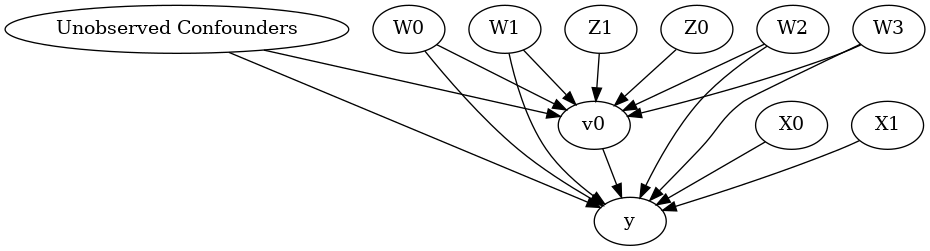

In [4]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [5]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W3,W2,W1,X1,X0,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W1,X1,X0,W0,U) = P(y|v0,W3,W2,W1,X1,X0,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [6]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W3,W2,W1,X1,X0,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W1,X1,X0,W0,U) = P(y|v0,W3,W2,W1,X1,X0,W0)

## Realized estimand
b: y~v0+W3+W2+W1+X1+X0+W0+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 11.138323583866043
### Conditional Estimates
__categorical__X1  __categorical__X0
(-3.742, -1.16]    (-3.816, -0.439]      5.350980
                   (-0.439, 0.172]       8.452173
                   (0.172, 0.677]       10.231967
                   (0.677, 1.246]       11.996779
                   (1.246, 4.411]       14.906734
(-1.16, -0.589]    (-3.816, -0.439]      5.981074
                   (-0.439, 0.172]       8.985925
                   (0.172, 0.677]       10.909247
                   (0.677, 1.24

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W3,W2,W1,X1,X0,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W1,X1,X0,W0,U) = P(y|v0,W3,W2,W1,X1,X0,W0)

## Realized estimand
b: y~v0+W3+W2+W1+X1+X0+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 15.15260356848542
Effect estimates: [15.33955778 15.84879232 14.66910411 ... 18.4715256  14.39605376
 17.57646996]



In [8]:
print("True causal estimate is", data["ate"])

True causal estimate is 11.13817451301838


In [9]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W3,W2,W1,X1,X0,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W1,X1,X0,W0,U) = P(y|v0,W3,W2,W1,X1,X0,W0)

## Realized estimand
b: y~v0+W3+W2+W1+X1+X0+W0 | X1,X0
Target units: 

## Estimate
Mean value: 11.037725784237395
Effect estimates: [15.27390981 11.5084465  11.0123769  ...  7.07033426 11.24713532
 10.45835842]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W3,W2,W1,X1,X0,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W1,X1,X0,W0,U) = P(y|v0,W3,W2,W1,X1,X0,W0)

## Realized estimand
b: y~v0+W3+W2+W1+X1+X0+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 11.03107854161636
Effect estimates: [15.23154757 11.4914362  11.00644985 ...  7.09605105 11.23996513
 10.45151404]
95.0% confidence interval: (array([15.20814535, 11.43427515, 10.97728669, ...,  6.92179496,
       11.21199051, 10.40377708]), array([15.53654796, 11.69017454, 11.10728956, ...,  7.17041884,
       11.35021865, 10.56899233]))



### Can provide a new inputs as target units and estimate CATE on them.

In [11]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[11.09338659 12.13565105 11.3207331  12.64976079 13.0817584  12.11993925
 11.57045914 11.44465176 13.48497597 11.05031631]


### Can also retrieve the raw EconML estimator object for any further operations

In [12]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [13]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     0.607055 -1.614792  1.0  0.455616  1.221222 -0.648731  1.326302   
1     2.993224 -0.200924  0.0  0.311552 -0.804113  0.837046 -0.219313   
2     1.991809  1.339323  0.0  0.177437  0.541844 -1.252206 -0.018509   
3     1.375978  0.476735  1.0  0.549200 -1.052208 -1.242290  0.363920   
4     0.802443 -0.904535  0.0  0.348527  1.370334 -0.536766 -0.011914   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.376158 -0.719342  0.0  0.213180 -0.463657 -1.072515 -1.974591   
9996  0.116404  2.395842  0.0  0.153815  1.254356 -1.060713  1.624262   
9997  0.514493 -0.307350  1.0  0.048421 -0.141551  0.897432 -0.602098   
9998  0.715935 -1.660456  0.0  0.895173 -0.653106  2.064832 -0.931449   
9999  1.145919 -1.137355  1.0  0.068377  1.188003 -0.917376 -0.878206   

            W3  v0  y  
0    -0.496089   1  1  
1    -0.455882   0  1  
2     0.276731   1  1  
3     0.027972   1  1  
4  

#### Using DRLearner estimator

In [14]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                    
─────(Expectation(y|W3,W2,W1,X1,X0,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,W1,X1,X0,W0,U) = P(y|v0,W3,W2,W1,X1,X0,W0)

## Realized estimand
b: y~v0+W3+W2+W1+X1+X0+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 0.48099941411381597
Effect estimates: [0.34133643 0.58394521 0.69402234 ... 0.46721726 0.34146445 0.41183014]

True causal estimate is 0.3833


### Instrumental Variable Method

In [15]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model._instruments)+len(model._effect_modifiers)
dims_tx = len(model._treatment)+len(model._effect_modifiers)
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

Using TensorFlow backend.


Epoch 1/25
10000/10000 [==============================] - 2s 158us/step - loss: 6.0581
Epoch 2/25
10000/10000 [==============================] - 1s 90us/step - loss: 2.5423
Epoch 3/25
10000/10000 [==============================] - 1s 88us/step - loss: 2.3626
Epoch 4/25
10000/10000 [==============================] - 1s 87us/step - loss: 2.3099
Epoch 5/25
10000/10000 [==============================] - 1s 87us/step - loss: 2.2638
Epoch 6/25
10000/10000 [==============================] - 1s 99us/step - loss: 2.2351
Epoch 7/25
10000/10000 [==============================] - 1s 94us/step - loss: 2.2353
Epoch 8/25
10000/10000 [==============================] - 1s 83us/step - loss: 2.2118
Epoch 9/25
10000/10000 [==============================] - 1s 84us/step - loss: 2.2095
Epoch 10/25
10000/10000 [==============================] - 1s 83us/step - loss: 2.1964
Epoch 11/25
10000/10000 [==============================] - 1s 83us/step - loss: 2.1899
Epoch 12/25
10000/10000 [==========================

### Metalearners

In [16]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -1.511404 -0.796794  0.381156  0.546913  0.988627  1.0  0.945576   
1     1.084781 -1.922791 -0.461289 -0.208160 -1.362516  0.0  0.631043   
2    -0.993879  0.264821  2.495885  0.768880 -0.200069  1.0  0.564980   
3    -2.752826 -1.278350  2.013659  0.225430 -0.296333  1.0  0.729429   
4    -0.176540 -0.143080 -1.994730  1.445114 -1.310322  0.0  0.660578   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -0.615514 -0.054405 -1.403155  0.047062  0.668092  0.0  0.049970   
9996 -0.079075 -1.970365  0.590612  0.129645  1.702936  0.0  0.006828   
9997 -0.612788 -1.583195 -0.955393  0.139663  0.633461  0.0  0.622620   
9998 -2.649140 -1.605903 -1.236836 -1.253810 -1.396432  0.0  0.394677   
9999 -1.006696  0.406869 -0.687812  0.247259  0.680919  0.0  0.069656   

            W0        W1        W2        W3        W4  v0          y  
0     0.083088 -0.950762  0.474662  1.346305 -1.790

In [17]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                
─────(Expectation(y|W3,W2,X4,W1,X3,X1,X2,W4,X0,W0))
d[v₀]                                              
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W2,X4,W1,X3,X1,X2,W4,X0,W0,U) = P(y|v0,W3,W2,X4,W1,X3,X1,X2,W4,X0,W0)

## Realized estimand
b: y~v0+X3+X2+X1+X4+X0+W3+W2+W1+W4+W0
Target units: ate

## Estimate
Mean value: 6.287323303624039
Effect estimates: [ 4.61465613 12.53217671  8.69905637 ...  6.04112821 -3.265252
  6.54000794]

True causal estimate is 5.535602451644429


## Refuting the estimate

### Adding a random common cause variable

In [18]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:11.995163235677346
New effect:12.028609904102334



### Adding an unobserved common cause variable

In [19]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:11.995163235677346
New effect:12.046656228321476



### Replacing treatment with a random (placebo) variable

In [20]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:11.995163235677346
New effect:0.014174758181060527
p value:0.40645666707426864



### Removing a random subset of the data

In [21]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:11.995163235677346
New effect:11.998974744372351
p value:0.46530895233272207



More refutation methods to come, especially specific to the CATE estimators.